# POSEIDON: Pose Estimation & Activity Recognition using GNNs

Team Members (Group 16): 
1. Chong Jun Rong Brian (A0290882U)
2. Parashara Ramesh (A0285647M)
3. Ng Wei Jie Brandon (A0184893L)

In [ ]:
%load_ext autoreload
%autoreload 2

<h2><u> Table of contents </u></h2>

1. What is this project about?
<br> 1.1. Project Motivation
<br> 1.2. Project Description
<br> 1.3. Project Setup   
2. Human 3.6M Dataset
<br> 2.1. Summary of the dataset
<br> 2.2. Preparing the dataset
<br> 2.3. Visualizing poses
3. Model building approach
4. Baseline 1 - SimplePose (Simple ML model without using GNNs)
5. Baseline 2 - SimplePoseGNN (Simple ML model using GNNs) 
6. Improvement 1 - SimplePoseGAT (Using 2 layers of GATConv)
7. Improvement 2 - SemGCN model (Reimplementation of Semantic GCN)
8. Evaluation & Analysis of models
9. Creating our own custom dataset
10. Evaluation on custom dataset
11. Conclusion
12. Video presentation & Resources


<h2><u>1. What is this project about?</u></h2>
<h3><u>1.1 Project Motivation</u></h3>

Accurately predicting 3D human poses from 2D keypoints is a critical task for many applications such as motion capture and activity recognition. Traditional methods that use direct regression or lifting techniques often struggle to fully capture the complex spatial relationships between body joints. By treating the 2D pose keypoints as graphs, we can leverage the underlying connectivity between joints to improve the 3D pose estimation. Additionally, recognizing and classifying human activities from these poses is an essential task in fields like surveillance and healthcare. Therefore, this project seeks to explore how GNNs can enhance 3D pose estimation and activity recognition.

<h3><u>1.2 Project Description</h3></u>

The primary objective of this project is to predict 3D human poses from 2D pose keypoints accurately using GNNs. 
* Firstly, we will develop two baseline models: one using standard Neural Network (NN) & Convolutional Neural Network (CNN) followed by a simple GNN based model both for 3d pose estimation 
* Secondly, we will reimplement the SemGCN model, which treats the body joints of a 2D pose as nodes in a graph, with edges representing the connectivity between them. 
* Finally, we will design an improved version of the SemGCN model by exploring different GNN architectures and modifications to enhance its performance.

The secondary objective is to classify human activities based on 2D pose keypoints. We will use custom datasets to validate this task, allowing us to assess the generalization capabilities of GNN-based models for activity recognition.

<h3><u>1.3 Project Setup</u></h3>

1. Install the dependencies from requirements.txt using the command

`pip install -r requirements.txt`


<h2><u>2. Human 3.6M Dataset</u></h2>

<h3><u>2.1 Summary of the dataset </u></h3>

The [Human 3.6M dataset](http://vision.imar.ro/human3.6m/description.php) is a large-scale collection of 3.6 million 3D human poses captured from 11 professional actors in 17 everyday scenarios (e.g., talking, smoking, discussing). It includes synchronized video from multiple calibrated cameras, precise 3D joint positions and angles, and pixel-level body part labels. Additional data like time-of-flight range data and 3D laser scans of actors are also available.

The dataset comes with precomputed image descriptors, tools for visualizing and predicting human poses, and an evaluation set for benchmarking performance, making it a rich resource for 3D human pose estimation, action recognition, and related computer vision tasks.

<h3><u>2.2. Dataset preparation </u></h3>

Downloading the dataset from the website requires a login , therefore we will be directly using a preprocessed version of this dataset stored in google drive [here](https://drive.google.com/file/d/1JGt3j9q5A8WzUY-QKfyMVJUUvfreri-s/view?usp=drive_link).
 
Original preprocessing was done by [Martinez et al](https://github.com/una-dinosauria/3d-pose-baseline) from this repository.

The cells below go through the steps of downloading this preprocessed dataset and creating train-test files from it after some transformation. 

From section 3(Models) we will be directly using the created train-test files, therefore the cells under this section need not be executed.

#### Downloading the zip from google drive

In [ ]:
# Download the zip from google drive
import gdown
import os

# file id from gdrive (refer to markdown cell above for full link)
file_id = '1JGt3j9q5A8WzUY-QKfyMVJUUvfreri-s' 
download_url = f'https://drive.google.com/uc?id={file_id}'

# Folder where you want to save the file
folder_path = os.path.join(os.getcwd(),"datasets", "h36m", "Original")
zip_file_path = os.path.join(folder_path, 'h36m.zip')

# Ensure the folder exists
os.makedirs(folder_path, exist_ok=True)

# Download the ZIP file
gdown.download(download_url, zip_file_path, quiet=False)

print(f"Downloaded ZIP file and saved to {zip_file_path}")


#### Extracting the contents into the same folder

In [ ]:
# extracting the contents inside the /datasets/h36m/Original folder
import zipfile

print(f"Extracting files to {folder_path}..")
# Open the ZIP file and extract its contents
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(folder_path)

print(f"Finished extracting files to {folder_path}")



#### Saving the 3d positions into a compressed np file

In [ ]:
import h5py
from glob import glob
from tqdm import tqdm
import numpy as np

output_filename = os.path.join(folder_path, 'data_3d_h36m')
subjects = ['S1', 'S5', 'S6', 'S7', 'S8', 'S9', 'S11']

output = dict()
for subject in tqdm(subjects, desc= f'Processing subjects..'):
    output[subject] = dict()
    file_list = glob(os.path.join(folder_path, 'h36m', subject, 'MyPoses', '3D_positions', '*.h5'))
    assert len(file_list) == 30, "Expected 30 files for subject " + subject + ", got " + str(len(file_list))
    for f in file_list:
        action = os.path.splitext(os.path.basename(f))[0]

        if subject == 'S11' and action == 'Directions':
            continue  # Discard corrupted video

        with h5py.File(f) as hf:
            positions = hf.get('3D_positions')[:].reshape(32, 3, -1).transpose(2, 0, 1)
            positions /= 1000  # Meters instead of millimeters
            output[subject][action] = positions.astype('float32')

print(f'Saving compressed 3d positions into {output_filename}')
np.savez_compressed(output_filename, positions_3d=output)
print(f'Finished saving 3d positions into {output_filename}')
del output


#### Compute the ground truth 2d poses.

TODO.brandon explain what the human35mDataset constructor does in detail (intrinsics, extrinsics, cameras, normalization etc etc)

In [ ]:
from data.camera import world_to_camera, project_to_2d, image_coordinates, wrap
from data.h36m_dataset import Human36mDataset

print('Computing ground-truth 2D poses...')
output_filename_2d = os.path.join(folder_path, 'data_2d_h36m_gt')

dataset = Human36mDataset(output_filename + '.npz')
output_2d_poses = {}
for subject in dataset.subjects():
    output_2d_poses[subject] = {}
    for action in dataset[subject].keys():
        anim = dataset[subject][action]

        positions_2d = []
        for cam in anim['cameras']:
            pos_3d = world_to_camera(anim['positions'], R=cam['orientation'], t=cam['translation'])
            pos_2d = wrap(project_to_2d, True, pos_3d, cam['intrinsic'])
            pos_2d_pixel_space = image_coordinates(pos_2d, w=cam['res_w'], h=cam['res_h'])
            positions_2d.append(pos_2d_pixel_space.astype('float32'))
        output_2d_poses[subject][action] = positions_2d

print(f'Saving compressed 2d positions into {output_filename_2d}')
metadata = {
    'num_joints': dataset.skeleton().num_joints(),
    'keypoints_symmetry': [dataset.skeleton().joints_left(), dataset.skeleton().joints_right()]
}
np.savez_compressed(output_filename_2d, positions_2d=output_2d_poses, metadata=metadata)

print(f'Done saving compressed 2d positions into {output_filename_2d}')
del output_2d_poses

#### Cleanup the extracted files and the downloaded zip

In [ ]:
from shutil import rmtree

rmtree(os.path.join(folder_path, 'h36m'))
os.remove(os.path.join(folder_path, 'h36m.zip'))

#### Creating and saving train and test files from the saved npz files

In [ ]:
from utils.data_utils import read_3d_data, create_2d_data, create_train_test_files
from data.h36m_dataset import TRAIN_SUBJECTS, TEST_SUBJECTS, Human36mDataset
import os

subjects_train = TRAIN_SUBJECTS
subjects_test = TEST_SUBJECTS

processed_dataset_path = os.path.join(os.getcwd(), "datasets", "h36m", "Processed")
os.makedirs(processed_dataset_path, exist_ok=True)

dataset_path = os.path.join(os.getcwd(), "datasets", "h36m", "Original", "data_3d_h36m.npz")
dataset = Human36mDataset(dataset_path)


In [ ]:
#TODO.brandon: add comments for what exactly the read_3d_data function does and the create_2d_data does.
print("Reading 3d npz file")
dataset = read_3d_data(dataset)

print("Reading 2d npz file")
dataset_2d_path = os.path.join(os.getcwd(), "datasets", "h36m", "Original", "data_2d_h36m_gt.npz")
keypoints = create_2d_data(dataset_2d_path, dataset)
print("Done")

In [ ]:
print("Creating train datasets and saving into file")
_, _, _ = create_train_test_files(subjects_train, dataset, keypoints, "train", processed_dataset_path)

print("Creating test datasets and saving into file")
_, _, _ = create_train_test_files(subjects_test, dataset, keypoints, "test", processed_dataset_path)
print("Done")

<h3><u>2.3 Visualizing poses </u></h3>

Since we have saved the train and test files, we will now only use those files for the rest of the notebook.

This has also been saved directly in this [google drive link](https://drive.google.com/drive/folders/1d38hWSM8clZlI11nqljxBECog1KY-iTd?usp=sharing), which can be placed directly in the local path instead of executing previous cells.

The visualizations below shows that we are considering that human poses are comprised of skeletons with just 16 joints after doing all of the processing above.

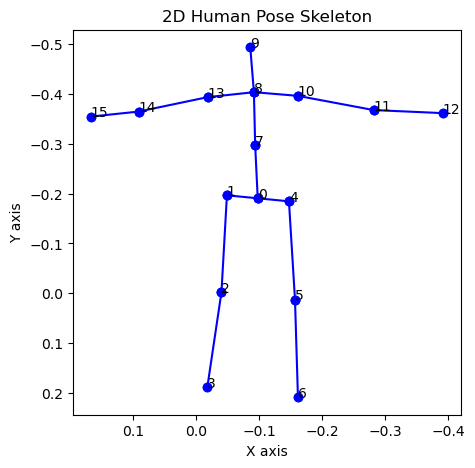

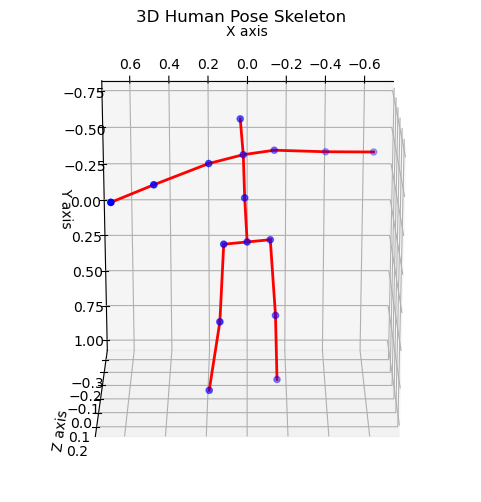

In [5]:
import numpy as np

from utils.visualization_utils import visualize_2d_pose, visualize_3d_pose

poses_2d = np.load("datasets/h36m/Processed/test_2d_poses.npy")
poses_3d = np.load("datasets/h36m/Processed/test_3d_poses.npy")

visualize_2d_pose(poses_2d[0])
visualize_3d_pose(poses_3d[0], elev=110, azim=90)

#### Finding out the distribution of actions in the train and test splits

The following code cells plots a bar graph of the actions in the train and test datasets.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def show_action_stats(actions, type):
    train_actions_df = pd.DataFrame(actions, columns=['actions'])
    action_counts = train_actions_df['actions'].value_counts()
    print(action_counts)
    
    action_counts.plot(kind='bar')
    
    # Step 4: Show the plot
    plt.title(f'{type} Action Distribution')
    plt.xlabel('Action')
    plt.ylabel('Count')
    plt.show()


In [ ]:
train_actions = np.load("datasets/h36m/Processed/train_actions.npy")
show_action_stats(train_actions, "Train")

In [ ]:
import torch 
import torch.nn as nn

w = nn.Parameter(torch.Tensor(size=(2,5,5)))

In [ ]:
test_actions = np.load("datasets/h36m/Processed/test_actions.npy")
show_action_stats(train_actions, "Test")

<h2><u>3. Model Building Approach</u></h2>

The following sections attempts to build different ML models using the dataset which was just constructed above.

At a very high level these are the models we aim to build:
* SimplePose - A simple baseline ML model using classic DL layers
* SimplePoseGNN - A simple baseline GNN model using DGL and GNN layers
* SemGCN - A reimplementation of the [SemGCN paper](https://arxiv.org/abs/1904.03345) in DGL
* PoseGCN - A more complex GNN model by leveraging the insights gained from building the other GNN models.


<h2><u>4. Baseline 1 - SimplePose (Simple ML model without using GNNs)</u></h2>

TODO.brian - write something meaningful here



In [1]:
from src.simple_pose.train_and_test import training_loop
from argparse import Namespace
import os
from datetime import datetime
timestamp = datetime.now().strftime("%Y-%m-%d--%H-%M-%S")

args_dict = {
    'learning_rate': 3e-5,
    'num_epochs': 30,
    'batch_size': 256,
    'action_loss_multiplier': 0.005,
    'pose_loss_multiplier': 0.995,
    'training_2d_data_path': os.path.join('datasets', 'custom', 'Processed', 'train_2d_poses.npy'),
    'training_3d_data_path': os.path.join('datasets', 'custom', 'Processed', 'train_3d_poses.npy'),
    'training_label_path': os.path.join('datasets', 'custom', 'Processed', 'train_actions.npy'),
    'testing_2d_data_path': os.path.join('datasets', 'custom', 'Processed', 'test_2d_poses.npy'),
    'testing_3d_data_path': os.path.join('datasets', 'custom', 'Processed', 'test_3d_poses.npy'),
    'testing_label_path': os.path.join('datasets', 'custom', 'Processed', 'test_actions.npy'),
    'save_path': os.path.join('model_outputs', 'simple_pose', timestamp)
}
args = Namespace(**args_dict)
training_loop(args)

INFO:root:Model is currently using : cuda
INFO:root:Creating Missing Paths: model_outputs\simple_pose\2024-11-13--11-52-41
INFO:root:Saving config
INFO:root:Setup Training and Testing Dataloaders


Training args are: Namespace(action_loss_multiplier=0.005, batch_size=256, learning_rate=3e-05, num_epochs=30, pose_loss_multiplier=0.995, save_path='model_outputs\\simple_pose\\2024-11-13--11-52-41', testing_2d_data_path='datasets\\custom\\Processed\\test_2d_poses.npy', testing_3d_data_path='datasets\\custom\\Processed\\test_3d_poses.npy', testing_label_path='datasets\\custom\\Processed\\test_actions.npy', training_2d_data_path='datasets\\custom\\Processed\\train_2d_poses.npy', training_3d_data_path='datasets\\custom\\Processed\\train_3d_poses.npy', training_label_path='datasets\\custom\\Processed\\train_actions.npy')


INFO:root:Setup SimplePose model with Kaiming Weights
INFO:root:SimplePose(
  (input_linear_2d): Linear(in_features=26, out_features=1024, bias=True)
  (blocks): ModuleList(
    (0-5): 6 x Sequential(
      (0): Linear(in_features=1024, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.6, inplace=False)
      (4): Linear(in_features=1024, out_features=1024, bias=True)
      (5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): Dropout(p=0.6, inplace=False)
    )
  )
  (output_3d_pose_linear): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.6, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=

Starting EPOCH: 1 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 99.70it/s] 


Saving at epoch 0
Epoch: 0 | Total Training Loss: 1.3647841215133667 | Pose Training Loss: 1.3643653392791748 | Action Training Loss: 1.4481199979782104 | Action Train Label Accuracy: 39.029011617071504


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 297.88it/s]
INFO:root:Saving model current state


Epoch: 0 | Total Testing Loss: 0.13105157017707825 | Pose Testing Loss: 0.1196637749671936 | Action Testing Loss: 2.3972208499908447 | Action Test Label Accuracy: 20.0
Starting EPOCH: 2 / 30


Training =>: 100%|██████████| 126/126 [00:00<00:00, 127.51it/s]


Saving at epoch 1
Epoch: 1 | Total Training Loss: 0.7367621064186096 | Pose Training Loss: 0.7354615330696106 | Action Training Loss: 0.9956101179122925 | Action Train Label Accuracy: 54.090824377213146


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 298.21it/s]
INFO:root:Saving model current state


Epoch: 1 | Total Testing Loss: 0.09941070526838303 | Pose Testing Loss: 0.0876048281788826 | Action Testing Loss: 2.4487802982330322 | Action Test Label Accuracy: 20.0
Starting EPOCH: 3 / 30


Training =>: 100%|██████████| 126/126 [00:00<00:00, 128.61it/s]


Saving at epoch 2
Epoch: 2 | Total Training Loss: 0.4259212613105774 | Pose Training Loss: 0.42361101508140564 | Action Training Loss: 0.8856843113899231 | Action Train Label Accuracy: 59.18494129340871


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 256.55it/s]
INFO:root:Saving model current state


Epoch: 2 | Total Testing Loss: 0.07716955989599228 | Pose Testing Loss: 0.06578406691551208 | Action Testing Loss: 2.3428800106048584 | Action Test Label Accuracy: 20.0
Starting EPOCH: 4 / 30


Training =>: 100%|██████████| 126/126 [00:00<00:00, 130.09it/s]


Saving at epoch 3
Epoch: 3 | Total Training Loss: 0.2696590721607208 | Pose Training Loss: 0.26671093702316284 | Action Training Loss: 0.8563385605812073 | Action Train Label Accuracy: 61.08591663042803


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 306.35it/s]
INFO:root:Saving model current state


Epoch: 3 | Total Testing Loss: 0.06954345852136612 | Pose Testing Loss: 0.05841973051428795 | Action Testing Loss: 2.2831647396087646 | Action Test Label Accuracy: 20.0
Starting EPOCH: 5 / 30


Training =>: 100%|██████████| 126/126 [00:00<00:00, 128.94it/s]


Saving at epoch 4
Epoch: 4 | Total Training Loss: 0.19574211537837982 | Pose Training Loss: 0.19253456592559814 | Action Training Loss: 0.8340342044830322 | Action Train Label Accuracy: 62.87196371994782


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 230.13it/s]
INFO:root:Saving model current state


Epoch: 4 | Total Testing Loss: 0.07087962329387665 | Pose Testing Loss: 0.06105373054742813 | Action Testing Loss: 2.026233196258545 | Action Test Label Accuracy: 23.916666666666668
Starting EPOCH: 6 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 125.28it/s]


Saving at epoch 5
Epoch: 5 | Total Training Loss: 0.15464694797992706 | Pose Training Loss: 0.15133388340473175 | Action Training Loss: 0.8139444589614868 | Action Train Label Accuracy: 64.25420885879356


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 289.76it/s]
INFO:root:Saving model current state


Epoch: 5 | Total Testing Loss: 0.07078581303358078 | Pose Testing Loss: 0.06050560623407364 | Action Testing Loss: 2.1165480613708496 | Action Test Label Accuracy: 22.0
Starting EPOCH: 7 / 30


Training =>: 100%|██████████| 126/126 [00:00<00:00, 130.57it/s]


Saving at epoch 6
Epoch: 6 | Total Training Loss: 0.13000856339931488 | Pose Training Loss: 0.12671665847301483 | Action Training Loss: 0.7851070165634155 | Action Train Label Accuracy: 65.82282412871963


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 289.19it/s]
INFO:root:Saving model current state


Epoch: 6 | Total Testing Loss: 0.06998728960752487 | Pose Testing Loss: 0.0605500303208828 | Action Testing Loss: 1.948001503944397 | Action Test Label Accuracy: 24.333333333333336
Starting EPOCH: 8 / 30


Training =>: 100%|██████████| 126/126 [00:00<00:00, 126.90it/s]


Saving at epoch 7
Epoch: 7 | Total Training Loss: 0.11326421052217484 | Pose Training Loss: 0.11006448417901993 | Action Training Loss: 0.7500097751617432 | Action Train Label Accuracy: 67.8231968689818


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 288.19it/s]
INFO:root:Saving model current state


Epoch: 7 | Total Testing Loss: 0.0659634917974472 | Pose Testing Loss: 0.05652277544140816 | Action Testing Loss: 1.944666862487793 | Action Test Label Accuracy: 25.124999999999996
Starting EPOCH: 9 / 30


Training =>: 100%|██████████| 126/126 [00:00<00:00, 135.12it/s]


Saving at epoch 8
Epoch: 8 | Total Training Loss: 0.10085432976484299 | Pose Training Loss: 0.09776653349399567 | Action Training Loss: 0.7153230309486389 | Action Train Label Accuracy: 69.89811766167608


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 338.01it/s]
INFO:root:Saving model current state


Epoch: 8 | Total Testing Loss: 0.06089708209037781 | Pose Testing Loss: 0.05275363475084305 | Action Testing Loss: 1.6814441680908203 | Action Test Label Accuracy: 34.875
Starting EPOCH: 10 / 30


Training =>: 100%|██████████| 126/126 [00:00<00:00, 131.51it/s]


Saving at epoch 9
Epoch: 9 | Total Training Loss: 0.09122423827648163 | Pose Training Loss: 0.08827321231365204 | Action Training Loss: 0.6784720420837402 | Action Train Label Accuracy: 71.74318195937131


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 276.54it/s]
INFO:root:Saving model current state


Epoch: 9 | Total Testing Loss: 0.056346651166677475 | Pose Testing Loss: 0.048058465123176575 | Action Testing Loss: 1.7056941986083984 | Action Test Label Accuracy: 34.75
Starting EPOCH: 11 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 118.06it/s]


Saving at epoch 10
Epoch: 10 | Total Training Loss: 0.0829797014594078 | Pose Training Loss: 0.08016686141490936 | Action Training Loss: 0.6427298188209534 | Action Train Label Accuracy: 73.28384170963534


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 220.58it/s]
INFO:root:Saving model current state


Epoch: 10 | Total Testing Loss: 0.05306936055421829 | Pose Testing Loss: 0.045481327921152115 | Action Testing Loss: 1.5630884170532227 | Action Test Label Accuracy: 39.958333333333336
Starting EPOCH: 12 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 113.96it/s]


Saving at epoch 11
Epoch: 11 | Total Training Loss: 0.07625842839479446 | Pose Training Loss: 0.07358849793672562 | Action Training Loss: 0.6075688600540161 | Action Train Label Accuracy: 74.94253587625023


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 201.95it/s]
INFO:root:Saving model current state


Epoch: 11 | Total Testing Loss: 0.04951292648911476 | Pose Testing Loss: 0.04220067709684372 | Action Testing Loss: 1.504650592803955 | Action Test Label Accuracy: 40.416666666666664
Starting EPOCH: 13 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 107.85it/s]


Saving at epoch 12
Epoch: 12 | Total Training Loss: 0.07058906555175781 | Pose Training Loss: 0.0680307000875473 | Action Training Loss: 0.5797043442726135 | Action Train Label Accuracy: 76.11356153320494


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 237.67it/s]
INFO:root:Saving model current state


Epoch: 12 | Total Testing Loss: 0.045211195945739746 | Pose Testing Loss: 0.038429997861385345 | Action Testing Loss: 1.3946692943572998 | Action Test Label Accuracy: 43.666666666666664
Starting EPOCH: 14 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 85.22it/s]


Saving at epoch 13
Epoch: 13 | Total Training Loss: 0.06568925827741623 | Pose Training Loss: 0.06327677518129349 | Action Training Loss: 0.545780599117279 | Action Train Label Accuracy: 77.75983102441448


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 198.81it/s]
INFO:root:Saving model current state


Epoch: 13 | Total Testing Loss: 0.042313989251852036 | Pose Testing Loss: 0.03522465005517006 | Action Testing Loss: 1.4530913829803467 | Action Test Label Accuracy: 41.625
Starting EPOCH: 15 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 109.37it/s]


Saving at epoch 14
Epoch: 14 | Total Training Loss: 0.061377715319395065 | Pose Training Loss: 0.05907562002539635 | Action Training Loss: 0.5194962620735168 | Action Train Label Accuracy: 79.01472324035535


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 252.97it/s]
INFO:root:Saving model current state


Epoch: 14 | Total Testing Loss: 0.03973926231265068 | Pose Testing Loss: 0.0334186889231205 | Action Testing Loss: 1.297533392906189 | Action Test Label Accuracy: 44.5
Starting EPOCH: 16 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 99.81it/s]


Saving at epoch 15
Epoch: 15 | Total Training Loss: 0.0575028695166111 | Pose Training Loss: 0.055297479033470154 | Action Training Loss: 0.49637311697006226 | Action Train Label Accuracy: 79.76952227123067


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 273.88it/s]
INFO:root:Saving model current state


Epoch: 15 | Total Testing Loss: 0.038038164377212524 | Pose Testing Loss: 0.03129258751869202 | Action Testing Loss: 1.3804072141647339 | Action Test Label Accuracy: 42.541666666666664
Starting EPOCH: 17 / 30


Training =>: 100%|██████████| 126/126 [00:00<00:00, 126.32it/s]


Saving at epoch 16
Epoch: 16 | Total Training Loss: 0.05377492308616638 | Pose Training Loss: 0.05167578160762787 | Action Training Loss: 0.47150304913520813 | Action Train Label Accuracy: 80.94054792818538


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 299.02it/s]
INFO:root:Saving model current state


Epoch: 16 | Total Testing Loss: 0.03602373227477074 | Pose Testing Loss: 0.029919907450675964 | Action Testing Loss: 1.2506847381591797 | Action Test Label Accuracy: 44.333333333333336
Starting EPOCH: 18 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 125.72it/s]


Saving at epoch 17
Epoch: 17 | Total Training Loss: 0.05099783465266228 | Pose Training Loss: 0.049006387591362 | Action Training Loss: 0.44729238748550415 | Action Train Label Accuracy: 82.37249176865255


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 266.17it/s]
INFO:root:Saving model current state


Epoch: 17 | Total Testing Loss: 0.034788161516189575 | Pose Testing Loss: 0.02848101034760475 | Action Testing Loss: 1.2899112701416016 | Action Test Label Accuracy: 43.666666666666664
Starting EPOCH: 19 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 116.14it/s]


Saving at epoch 18
Epoch: 18 | Total Training Loss: 0.04821719229221344 | Pose Training Loss: 0.046307273209095 | Action Training Loss: 0.4282938539981842 | Action Train Label Accuracy: 82.81046157669131


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 249.90it/s]
INFO:root:Saving model current state


Epoch: 18 | Total Testing Loss: 0.03337742015719414 | Pose Testing Loss: 0.027250593528151512 | Action Testing Loss: 1.2526150941848755 | Action Test Label Accuracy: 45.33333333333333
Starting EPOCH: 20 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 116.27it/s]


Saving at epoch 19
Epoch: 19 | Total Training Loss: 0.045823950320482254 | Pose Training Loss: 0.04400362819433212 | Action Training Loss: 0.408067524433136 | Action Train Label Accuracy: 83.68950736162017


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 197.96it/s]
INFO:root:Saving model current state


Epoch: 19 | Total Testing Loss: 0.03203028067946434 | Pose Testing Loss: 0.026084577664732933 | Action Testing Loss: 1.2152246236801147 | Action Test Label Accuracy: 46.541666666666664
Starting EPOCH: 21 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 115.53it/s]


Saving at epoch 20
Epoch: 20 | Total Training Loss: 0.04358678311109543 | Pose Training Loss: 0.04183187335729599 | Action Training Loss: 0.392813116312027 | Action Train Label Accuracy: 84.37907684661738


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 260.99it/s]
INFO:root:Saving model current state


Epoch: 20 | Total Testing Loss: 0.031264543533325195 | Pose Testing Loss: 0.025303153321146965 | Action Testing Loss: 1.2175817489624023 | Action Test Label Accuracy: 48.375
Starting EPOCH: 22 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 110.52it/s]


Saving at epoch 21
Epoch: 21 | Total Training Loss: 0.04175307974219322 | Pose Training Loss: 0.040068816393613815 | Action Training Loss: 0.3769187331199646 | Action Train Label Accuracy: 85.12766353979002


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 222.22it/s]
INFO:root:Saving model current state


Epoch: 21 | Total Testing Loss: 0.030373362824320793 | Pose Testing Loss: 0.02456533908843994 | Action Testing Loss: 1.1861696243286133 | Action Test Label Accuracy: 51.416666666666664
Starting EPOCH: 23 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 114.20it/s]


Saving at epoch 22
Epoch: 22 | Total Training Loss: 0.04003185033798218 | Pose Training Loss: 0.03842546418309212 | Action Training Loss: 0.35970398783683777 | Action Train Label Accuracy: 85.95701062309747


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 243.92it/s]
INFO:root:Saving model current state


Epoch: 22 | Total Testing Loss: 0.029789825901389122 | Pose Testing Loss: 0.024217447265982628 | Action Testing Loss: 1.1386935710906982 | Action Test Label Accuracy: 52.0
Starting EPOCH: 24 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 90.71it/s]


Saving at epoch 23
Epoch: 23 | Total Training Loss: 0.03850667551159859 | Pose Training Loss: 0.03695949167013168 | Action Training Loss: 0.3463973104953766 | Action Train Label Accuracy: 86.57513822451388


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 178.92it/s]
INFO:root:Saving model current state


Epoch: 23 | Total Testing Loss: 0.028537383303046227 | Pose Testing Loss: 0.0235439445823431 | Action Testing Loss: 1.0222315788269043 | Action Test Label Accuracy: 51.583333333333336
Starting EPOCH: 25 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 86.73it/s]


Saving at epoch 24
Epoch: 24 | Total Training Loss: 0.0370667465031147 | Pose Training Loss: 0.03558242321014404 | Action Training Loss: 0.3324470818042755 | Action Train Label Accuracy: 86.95409082437722


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 219.73it/s]
INFO:root:Saving model current state


Epoch: 24 | Total Testing Loss: 0.028683772310614586 | Pose Testing Loss: 0.02310495637357235 | Action Testing Loss: 1.138867735862732 | Action Test Label Accuracy: 52.541666666666664
Starting EPOCH: 26 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 91.39it/s]


Saving at epoch 25
Epoch: 25 | Total Training Loss: 0.03580189868807793 | Pose Training Loss: 0.034362830221652985 | Action Training Loss: 0.32217878103256226 | Action Train Label Accuracy: 87.2491768652544


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 220.51it/s]
INFO:root:Saving model current state


Epoch: 25 | Total Testing Loss: 0.02786940149962902 | Pose Testing Loss: 0.02298256941139698 | Action Testing Loss: 1.000348448753357 | Action Test Label Accuracy: 59.375
Starting EPOCH: 27 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 95.01it/s]


Saving at epoch 26
Epoch: 26 | Total Training Loss: 0.03481521084904671 | Pose Training Loss: 0.033444102853536606 | Action Training Loss: 0.30766552686691284 | Action Train Label Accuracy: 88.00086972727837


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 240.89it/s]
INFO:root:Saving model current state


Epoch: 26 | Total Testing Loss: 0.028440428897738457 | Pose Testing Loss: 0.022658368572592735 | Action Testing Loss: 1.1790698766708374 | Action Test Label Accuracy: 53.208333333333336
Starting EPOCH: 28 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 89.34it/s]


Saving at epoch 27
Epoch: 27 | Total Training Loss: 0.033784832805395126 | Pose Training Loss: 0.03246210888028145 | Action Training Loss: 0.29700666666030884 | Action Train Label Accuracy: 88.63452817295148


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 196.02it/s]
INFO:root:Saving model current state


Epoch: 27 | Total Testing Loss: 0.026901481673121452 | Pose Testing Loss: 0.022313788533210754 | Action Testing Loss: 0.9398523569107056 | Action Test Label Accuracy: 60.04166666666667
Starting EPOCH: 29 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 89.60it/s]


Saving at epoch 28
Epoch: 28 | Total Training Loss: 0.032911185175180435 | Pose Training Loss: 0.03162352740764618 | Action Training Loss: 0.2891553044319153 | Action Train Label Accuracy: 89.05386096788222


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 230.73it/s]
INFO:root:Saving model current state


Epoch: 28 | Total Testing Loss: 0.02722179889678955 | Pose Testing Loss: 0.02247507870197296 | Action Testing Loss: 0.9718189239501953 | Action Test Label Accuracy: 61.16666666666667
Starting EPOCH: 30 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 112.02it/s]


Saving at epoch 29
Epoch: 29 | Total Training Loss: 0.03208880499005318 | Pose Training Loss: 0.03085114061832428 | Action Training Loss: 0.27838248014450073 | Action Train Label Accuracy: 89.46076908740758


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 194.12it/s]
INFO:root:Saving model current state


Epoch: 29 | Total Testing Loss: 0.027437513694167137 | Pose Testing Loss: 0.02210535667836666 | Action Testing Loss: 1.0885374546051025 | Action Test Label Accuracy: 61.375


<Figure size 640x480 with 0 Axes>

<h2><u>5. Baseline 2 - SimplePoseGNN (Simple ML model using GNNs)</u></h2>

TODO.brian to write something meaningful here

In [2]:
from src.simple_pose_gnn.train_and_test import training_loop
from argparse import Namespace
import os
from datetime import datetime
timestamp = datetime.now().strftime("%Y-%m-%d--%H-%M-%S")

args_dict = {
    'learning_rate': 3e-5,
    'num_epochs': 30,
    'batch_size': 256,
    'action_loss_multiplier': 0.005,
    'pose_loss_multiplier': 0.995,
    'training_2d_data_path': os.path.join('datasets', 'custom', 'Processed', 'train_2d_poses.npy'),
    'training_3d_data_path': os.path.join('datasets', 'custom', 'Processed', 'train_3d_poses.npy'),
    'training_label_path': os.path.join('datasets', 'custom', 'Processed', 'train_actions.npy'),
    'testing_2d_data_path': os.path.join('datasets', 'custom', 'Processed', 'test_2d_poses.npy'),
    'testing_3d_data_path': os.path.join('datasets', 'custom', 'Processed', 'test_3d_poses.npy'),
    'testing_label_path': os.path.join('datasets', 'custom', 'Processed', 'test_actions.npy'),
    'save_path': os.path.join('model_outputs', 'simple_pose_gnn', timestamp)
}
args = Namespace(**args_dict)
training_loop(args)

INFO:root:Model is currently using : cuda
INFO:root:Creating Missing Paths: model_outputs\simple_pose_gnn\2024-11-13--11-53-33
INFO:root:Saving config
INFO:root:Setup Training and Testing Dataloaders
INFO:root:Setup SimplePoseGNN model
INFO:root:SimplePoseGNN(
  (input_layer): Linear(in_features=2, out_features=80, bias=True)
  (pos_linear): Linear(in_features=5, out_features=80, bias=True)
  (blocks): ModuleList(
    (0-5): 6 x Sequential(
      (0): GraphConvModule(
        (conv_1): GraphConv(in=80, out=80, normalization=both, activation=None)
        (batch_norm_1): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv_2): GraphConv(in=80, out=80, normalization=both, activation=None)
        (batch_norm_2): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (feed_forward_1): Linear(in_features=80, out_features=80, bias=True)
        (dropout): Dropout(p=0.5, inplace=False)
      )
      (1): GraphConvModul

Training args are: Namespace(action_loss_multiplier=0.005, batch_size=256, learning_rate=3e-05, num_epochs=30, pose_loss_multiplier=0.995, save_path='model_outputs\\simple_pose_gnn\\2024-11-13--11-53-33', testing_2d_data_path='datasets\\custom\\Processed\\test_2d_poses.npy', testing_3d_data_path='datasets\\custom\\Processed\\test_3d_poses.npy', testing_label_path='datasets\\custom\\Processed\\test_actions.npy', training_2d_data_path='datasets\\custom\\Processed\\train_2d_poses.npy', training_3d_data_path='datasets\\custom\\Processed\\train_3d_poses.npy', training_label_path='datasets\\custom\\Processed\\train_actions.npy')
(32194, 13, 2)
(2400, 13, 2)
Starting EPOCH: 1 / 30


Training =>: 100%|██████████| 126/126 [00:47<00:00,  2.65it/s]


Saving at epoch 0
Epoch: 0 | Total Training Loss: 0.2567999064922333 | Pose Training Loss: 0.2501493990421295 | Action Training Loss: 1.5802462100982666 | Action Train Label Accuracy: 26.734795303472698


Testing =>: 100%|██████████| 10/10 [00:28<00:00,  2.88s/it]
INFO:root:Saving model current state


Epoch: 0 | Total Testing Loss: 0.06815377622842789 | Pose Testing Loss: 0.06074831634759903 | Action Testing Loss: 1.5418407917022705 | Action Test Label Accuracy: 48.66666666666667
Starting EPOCH: 2 / 30


Training =>: 100%|██████████| 126/126 [00:44<00:00,  2.82it/s]


Saving at epoch 1
Epoch: 1 | Total Training Loss: 0.13878539204597473 | Pose Training Loss: 0.1318129152059555 | Action Training Loss: 1.5263115167617798 | Action Train Label Accuracy: 33.248431384730075


Testing =>: 100%|██████████| 10/10 [00:27<00:00,  2.74s/it]
INFO:root:Saving model current state


Epoch: 1 | Total Testing Loss: 0.06744959205389023 | Pose Testing Loss: 0.06035294011235237 | Action Testing Loss: 1.4796839952468872 | Action Test Label Accuracy: 54.37499999999999
Starting EPOCH: 3 / 30


Training =>: 100%|██████████| 126/126 [00:44<00:00,  2.84it/s]


Saving at epoch 2
Epoch: 2 | Total Training Loss: 0.0987435057759285 | Pose Training Loss: 0.09195473045110703 | Action Training Loss: 1.4497090578079224 | Action Train Label Accuracy: 39.98881779213518


Testing =>: 100%|██████████| 10/10 [00:27<00:00,  2.72s/it]
INFO:root:Saving model current state


Epoch: 2 | Total Testing Loss: 0.06576646119356155 | Pose Testing Loss: 0.059125710278749466 | Action Testing Loss: 1.387274980545044 | Action Test Label Accuracy: 54.0
Starting EPOCH: 4 / 30


Training =>: 100%|██████████| 126/126 [00:42<00:00,  2.97it/s]


Saving at epoch 3
Epoch: 3 | Total Training Loss: 0.08345673978328705 | Pose Training Loss: 0.07706370949745178 | Action Training Loss: 1.3556684255599976 | Action Train Label Accuracy: 44.772317823196865


Testing =>: 100%|██████████| 10/10 [00:27<00:00,  2.70s/it]
INFO:root:Saving model current state


Epoch: 3 | Total Testing Loss: 0.06097215414047241 | Pose Testing Loss: 0.05479646474123001 | Action Testing Loss: 1.2899341583251953 | Action Test Label Accuracy: 51.208333333333336
Starting EPOCH: 5 / 30


Training =>: 100%|██████████| 126/126 [00:42<00:00,  2.99it/s]


Saving at epoch 4
Epoch: 4 | Total Training Loss: 0.07584847509860992 | Pose Training Loss: 0.06992032378911972 | Action Training Loss: 1.2555521726608276 | Action Train Label Accuracy: 48.50593278250606


Testing =>: 100%|██████████| 10/10 [00:28<00:00,  2.88s/it]
INFO:root:Saving model current state


Epoch: 4 | Total Testing Loss: 0.05519779399037361 | Pose Testing Loss: 0.049406010657548904 | Action Testing Loss: 1.2077629566192627 | Action Test Label Accuracy: 51.5
Starting EPOCH: 6 / 30


Training =>: 100%|██████████| 126/126 [00:44<00:00,  2.86it/s]


Saving at epoch 5
Epoch: 5 | Total Training Loss: 0.07081251591444016 | Pose Training Loss: 0.06529916822910309 | Action Training Loss: 1.1679677963256836 | Action Train Label Accuracy: 51.587252283034104


Testing =>: 100%|██████████| 10/10 [00:29<00:00,  2.98s/it]
INFO:root:Saving model current state


Epoch: 5 | Total Testing Loss: 0.05052715539932251 | Pose Testing Loss: 0.045107074081897736 | Action Testing Loss: 1.129123330116272 | Action Test Label Accuracy: 52.583333333333336
Starting EPOCH: 7 / 30


Training =>: 100%|██████████| 126/126 [00:49<00:00,  2.54it/s]


Saving at epoch 6
Epoch: 6 | Total Training Loss: 0.06677276641130447 | Pose Training Loss: 0.061584290117025375 | Action Training Loss: 1.0992779731750488 | Action Train Label Accuracy: 53.76157047897123


Testing =>: 100%|██████████| 10/10 [00:28<00:00,  2.81s/it]
INFO:root:Saving model current state


Epoch: 6 | Total Testing Loss: 0.046068381518125534 | Pose Testing Loss: 0.04085240140557289 | Action Testing Loss: 1.084048867225647 | Action Test Label Accuracy: 54.79166666666667
Starting EPOCH: 8 / 30


Training =>: 100%|██████████| 126/126 [00:55<00:00,  2.28it/s]


Saving at epoch 7
Epoch: 7 | Total Training Loss: 0.06337163597345352 | Pose Training Loss: 0.05844347923994064 | Action Training Loss: 1.044080138206482 | Action Train Label Accuracy: 55.24942535876251


Testing =>: 100%|██████████| 10/10 [00:27<00:00,  2.76s/it]
INFO:root:Saving model current state


Epoch: 7 | Total Testing Loss: 0.0424678698182106 | Pose Testing Loss: 0.03751619905233383 | Action Testing Loss: 1.0278500318527222 | Action Test Label Accuracy: 60.04166666666667
Starting EPOCH: 9 / 30


Training =>: 100%|██████████| 126/126 [00:46<00:00,  2.73it/s]


Saving at epoch 8
Epoch: 8 | Total Training Loss: 0.06025382876396179 | Pose Training Loss: 0.055528007447719574 | Action Training Loss: 1.0006953477859497 | Action Train Label Accuracy: 56.74970491395912


Testing =>: 100%|██████████| 10/10 [00:28<00:00,  2.89s/it]
INFO:root:Saving model current state


Epoch: 8 | Total Testing Loss: 0.04015504941344261 | Pose Testing Loss: 0.035402487963438034 | Action Testing Loss: 0.9859153628349304 | Action Test Label Accuracy: 61.083333333333336
Starting EPOCH: 10 / 30


Training =>: 100%|██████████| 126/126 [00:47<00:00,  2.64it/s]


Saving at epoch 9
Epoch: 9 | Total Training Loss: 0.057406943291425705 | Pose Training Loss: 0.05286315456032753 | Action Training Loss: 0.9616146683692932 | Action Train Label Accuracy: 57.91141206435982


Testing =>: 100%|██████████| 10/10 [00:30<00:00,  3.02s/it]
INFO:root:Saving model current state


Epoch: 9 | Total Testing Loss: 0.03706410899758339 | Pose Testing Loss: 0.03247156739234924 | Action Testing Loss: 0.9509794116020203 | Action Test Label Accuracy: 62.74999999999999
Starting EPOCH: 11 / 30


Training =>: 100%|██████████| 126/126 [00:48<00:00,  2.61it/s]


Saving at epoch 10
Epoch: 10 | Total Training Loss: 0.054715417325496674 | Pose Training Loss: 0.05031333863735199 | Action Training Loss: 0.9307328462600708 | Action Train Label Accuracy: 59.4489656457725


Testing =>: 100%|██████████| 10/10 [00:28<00:00,  2.88s/it]
INFO:root:Saving model current state


Epoch: 10 | Total Testing Loss: 0.035142045468091965 | Pose Testing Loss: 0.03066982701420784 | Action Testing Loss: 0.925113320350647 | Action Test Label Accuracy: 62.83333333333333
Starting EPOCH: 12 / 30


Training =>: 100%|██████████| 126/126 [00:45<00:00,  2.75it/s]


Saving at epoch 11
Epoch: 11 | Total Training Loss: 0.052203595638275146 | Pose Training Loss: 0.04795346036553383 | Action Training Loss: 0.8979772925376892 | Action Train Label Accuracy: 60.719388705970054


Testing =>: 100%|██████████| 10/10 [00:27<00:00,  2.77s/it]
INFO:root:Saving model current state


Epoch: 11 | Total Testing Loss: 0.0326618030667305 | Pose Testing Loss: 0.028352035209536552 | Action Testing Loss: 0.8903056383132935 | Action Test Label Accuracy: 63.66666666666667
Starting EPOCH: 13 / 30


Training =>: 100%|██████████| 126/126 [00:46<00:00,  2.74it/s]


Saving at epoch 12
Epoch: 12 | Total Training Loss: 0.04975410923361778 | Pose Training Loss: 0.045637357980012894 | Action Training Loss: 0.8689864277839661 | Action Train Label Accuracy: 61.430701372926634


Testing =>: 100%|██████████| 10/10 [00:29<00:00,  2.90s/it]
INFO:root:Saving model current state


Epoch: 12 | Total Testing Loss: 0.03057307004928589 | Pose Testing Loss: 0.02642865478992462 | Action Testing Loss: 0.8553115129470825 | Action Test Label Accuracy: 64.625
Starting EPOCH: 14 / 30


Training =>: 100%|██████████| 126/126 [00:46<00:00,  2.71it/s]


Saving at epoch 13
Epoch: 13 | Total Training Loss: 0.047577664256095886 | Pose Training Loss: 0.04358771815896034 | Action Training Loss: 0.8415809869766235 | Action Train Label Accuracy: 62.84090203143443


Testing =>: 100%|██████████| 10/10 [00:27<00:00,  2.74s/it]
INFO:root:Saving model current state


Epoch: 13 | Total Testing Loss: 0.028831446543335915 | Pose Testing Loss: 0.024828046560287476 | Action Testing Loss: 0.8255082964897156 | Action Test Label Accuracy: 66.58333333333334
Starting EPOCH: 15 / 30


Training =>: 100%|██████████| 126/126 [00:47<00:00,  2.63it/s]


Saving at epoch 14
Epoch: 14 | Total Training Loss: 0.04542405903339386 | Pose Training Loss: 0.041563622653484344 | Action Training Loss: 0.8136500120162964 | Action Train Label Accuracy: 63.96222898676772


Testing =>: 100%|██████████| 10/10 [00:29<00:00,  2.93s/it]
INFO:root:Saving model current state


Epoch: 14 | Total Testing Loss: 0.027630550786852837 | Pose Testing Loss: 0.023792600259184837 | Action Testing Loss: 0.7913832664489746 | Action Test Label Accuracy: 67.41666666666667
Starting EPOCH: 16 / 30


Training =>: 100%|██████████| 126/126 [00:45<00:00,  2.79it/s]


Saving at epoch 15
Epoch: 15 | Total Training Loss: 0.04354534298181534 | Pose Training Loss: 0.03979125991463661 | Action Training Loss: 0.7906075119972229 | Action Train Label Accuracy: 65.06802509784431


Testing =>: 100%|██████████| 10/10 [00:28<00:00,  2.81s/it]
INFO:root:Saving model current state


Epoch: 15 | Total Testing Loss: 0.026475680992007256 | Pose Testing Loss: 0.022765612229704857 | Action Testing Loss: 0.7647792100906372 | Action Test Label Accuracy: 67.66666666666666
Starting EPOCH: 17 / 30


Training =>: 100%|██████████| 126/126 [00:42<00:00,  2.94it/s]


Saving at epoch 16
Epoch: 16 | Total Training Loss: 0.0419815257191658 | Pose Training Loss: 0.0383397601544857 | Action Training Loss: 0.7666926383972168 | Action Train Label Accuracy: 66.06199913027272


Testing =>: 100%|██████████| 10/10 [00:28<00:00,  2.81s/it]
INFO:root:Saving model current state


Epoch: 16 | Total Testing Loss: 0.025114333257079124 | Pose Testing Loss: 0.02158801071345806 | Action Testing Loss: 0.7268526554107666 | Action Test Label Accuracy: 70.0
Starting EPOCH: 18 / 30


Training =>: 100%|██████████| 126/126 [00:44<00:00,  2.84it/s]


Saving at epoch 17
Epoch: 17 | Total Training Loss: 0.040353018790483475 | Pose Training Loss: 0.03681303188204765 | Action Training Loss: 0.7448117733001709 | Action Train Label Accuracy: 66.62421569236504


Testing =>: 100%|██████████| 10/10 [00:27<00:00,  2.76s/it]
INFO:root:Saving model current state


Epoch: 17 | Total Testing Loss: 0.023823020979762077 | Pose Testing Loss: 0.020464984700083733 | Action Testing Loss: 0.6920725107192993 | Action Test Label Accuracy: 71.16666666666667
Starting EPOCH: 19 / 30


Training =>: 100%|██████████| 126/126 [00:43<00:00,  2.92it/s]


Saving at epoch 18
Epoch: 18 | Total Training Loss: 0.03892343118786812 | Pose Training Loss: 0.035509005188941956 | Action Training Loss: 0.7183910608291626 | Action Train Label Accuracy: 67.75486115425234


Testing =>: 100%|██████████| 10/10 [00:27<00:00,  2.77s/it]
INFO:root:Saving model current state


Epoch: 18 | Total Testing Loss: 0.02249547466635704 | Pose Testing Loss: 0.019187644124031067 | Action Testing Loss: 0.6807534098625183 | Action Test Label Accuracy: 71.83333333333334
Starting EPOCH: 20 / 30


Training =>: 100%|██████████| 126/126 [01:01<00:00,  2.04it/s]


Saving at epoch 19
Epoch: 19 | Total Training Loss: 0.037482015788555145 | Pose Training Loss: 0.03416069969534874 | Action Training Loss: 0.6984228491783142 | Action Train Label Accuracy: 68.6898179785053


Testing =>: 100%|██████████| 10/10 [00:31<00:00,  3.16s/it]
INFO:root:Saving model current state


Epoch: 19 | Total Testing Loss: 0.02139134332537651 | Pose Testing Loss: 0.018265804275870323 | Action Testing Loss: 0.6433734893798828 | Action Test Label Accuracy: 73.41666666666666
Starting EPOCH: 21 / 30


Training =>: 100%|██████████| 126/126 [00:49<00:00,  2.55it/s]


Saving at epoch 20
Epoch: 20 | Total Training Loss: 0.036147382110357285 | Pose Training Loss: 0.032923225313425064 | Action Training Loss: 0.6777550578117371 | Action Train Label Accuracy: 69.95713486985153


Testing =>: 100%|██████████| 10/10 [00:31<00:00,  3.14s/it]
INFO:root:Saving model current state


Epoch: 20 | Total Testing Loss: 0.0203385129570961 | Pose Testing Loss: 0.017308657988905907 | Action Testing Loss: 0.6232792735099792 | Action Test Label Accuracy: 74.83333333333333
Starting EPOCH: 22 / 30


Training =>: 100%|██████████| 126/126 [00:48<00:00,  2.60it/s]


Saving at epoch 21
Epoch: 21 | Total Training Loss: 0.03516783565282822 | Pose Training Loss: 0.032030634582042694 | Action Training Loss: 0.6594715118408203 | Action Train Label Accuracy: 70.419954028701


Testing =>: 100%|██████████| 10/10 [00:31<00:00,  3.17s/it]
INFO:root:Saving model current state


Epoch: 21 | Total Testing Loss: 0.019210878759622574 | Pose Testing Loss: 0.01639554277062416 | Action Testing Loss: 0.5794627070426941 | Action Test Label Accuracy: 77.625
Starting EPOCH: 23 / 30


Training =>: 100%|██████████| 126/126 [00:48<00:00,  2.62it/s]


Saving at epoch 22
Epoch: 22 | Total Training Loss: 0.0342092290520668 | Pose Training Loss: 0.03117150440812111 | Action Training Loss: 0.6387169361114502 | Action Train Label Accuracy: 71.57855501025035


Testing =>: 100%|██████████| 10/10 [00:28<00:00,  2.86s/it]
INFO:root:Saving model current state


Epoch: 22 | Total Testing Loss: 0.018841933459043503 | Pose Testing Loss: 0.016128642484545708 | Action Testing Loss: 0.5587864518165588 | Action Test Label Accuracy: 79.45833333333333
Starting EPOCH: 24 / 30


Training =>: 100%|██████████| 126/126 [00:44<00:00,  2.82it/s]


Saving at epoch 23
Epoch: 23 | Total Training Loss: 0.03332505002617836 | Pose Training Loss: 0.03038884326815605 | Action Training Loss: 0.6176294684410095 | Action Train Label Accuracy: 72.56321053612474


Testing =>: 100%|██████████| 10/10 [00:29<00:00,  2.91s/it]
INFO:root:Saving model current state


Epoch: 23 | Total Testing Loss: 0.018145330250263214 | Pose Testing Loss: 0.015573774464428425 | Action Testing Loss: 0.529884934425354 | Action Test Label Accuracy: 80.16666666666666
Starting EPOCH: 25 / 30


Training =>: 100%|██████████| 126/126 [00:45<00:00,  2.75it/s]


Saving at epoch 24
Epoch: 24 | Total Training Loss: 0.03246565908193588 | Pose Training Loss: 0.029619084671139717 | Action Training Loss: 0.5989341735839844 | Action Train Label Accuracy: 73.38945145058085


Testing =>: 100%|██████████| 10/10 [00:28<00:00,  2.90s/it]
INFO:root:Saving model current state


Epoch: 24 | Total Testing Loss: 0.01750214770436287 | Pose Testing Loss: 0.014990665018558502 | Action Testing Loss: 0.5172871947288513 | Action Test Label Accuracy: 81.25
Starting EPOCH: 26 / 30


Training =>: 100%|██████████| 126/126 [00:43<00:00,  2.88it/s]


Saving at epoch 25
Epoch: 25 | Total Training Loss: 0.03182263299822807 | Pose Training Loss: 0.02904515713453293 | Action Training Loss: 0.5845404863357544 | Action Train Label Accuracy: 74.26228489780704


Testing =>: 100%|██████████| 10/10 [00:27<00:00,  2.79s/it]
INFO:root:Saving model current state


Epoch: 25 | Total Testing Loss: 0.017056690528988838 | Pose Testing Loss: 0.014636816456913948 | Action Testing Loss: 0.4986114501953125 | Action Test Label Accuracy: 81.58333333333333
Starting EPOCH: 27 / 30


Training =>: 100%|██████████| 126/126 [00:44<00:00,  2.86it/s]


Saving at epoch 26
Epoch: 26 | Total Training Loss: 0.031087009236216545 | Pose Training Loss: 0.028413070365786552 | Action Training Loss: 0.5632001757621765 | Action Train Label Accuracy: 75.28732061874884


Testing =>: 100%|██████████| 10/10 [00:28<00:00,  2.83s/it]
INFO:root:Saving model current state


Epoch: 26 | Total Testing Loss: 0.01660809852182865 | Pose Testing Loss: 0.01435832865536213 | Action Testing Loss: 0.4643119275569916 | Action Test Label Accuracy: 82.5
Starting EPOCH: 28 / 30


Training =>: 100%|██████████| 126/126 [00:45<00:00,  2.80it/s]


Saving at epoch 27
Epoch: 27 | Total Training Loss: 0.030452564358711243 | Pose Training Loss: 0.02784528024494648 | Action Training Loss: 0.5493022203445435 | Action Train Label Accuracy: 76.44281543144686


Testing =>: 100%|██████████| 10/10 [00:28<00:00,  2.86s/it]
INFO:root:Saving model current state


Epoch: 27 | Total Testing Loss: 0.016185885295271873 | Pose Testing Loss: 0.014003735966980457 | Action Testing Loss: 0.4504334032535553 | Action Test Label Accuracy: 82.91666666666667
Starting EPOCH: 29 / 30


Training =>: 100%|██████████| 126/126 [00:44<00:00,  2.81it/s]


Saving at epoch 28
Epoch: 28 | Total Training Loss: 0.029800139367580414 | Pose Training Loss: 0.027262847870588303 | Action Training Loss: 0.5347194671630859 | Action Train Label Accuracy: 76.9429086165124


Testing =>: 100%|██████████| 10/10 [00:28<00:00,  2.84s/it]
INFO:root:Saving model current state


Epoch: 28 | Total Testing Loss: 0.015667185187339783 | Pose Testing Loss: 0.013597212731838226 | Action Testing Loss: 0.42759132385253906 | Action Test Label Accuracy: 83.75
Starting EPOCH: 30 / 30


Training =>: 100%|██████████| 126/126 [00:45<00:00,  2.75it/s]


Saving at epoch 29
Epoch: 29 | Total Training Loss: 0.029223846271634102 | Pose Training Loss: 0.026775676757097244 | Action Training Loss: 0.5164077877998352 | Action Train Label Accuracy: 77.72566316704976


Testing =>: 100%|██████████| 10/10 [00:28<00:00,  2.83s/it]
INFO:root:Saving model current state


Epoch: 29 | Total Testing Loss: 0.015493041835725307 | Pose Testing Loss: 0.013492538593709469 | Action Testing Loss: 0.4135932922363281 | Action Test Label Accuracy: 83.91666666666666


<Figure size 640x480 with 0 Axes>

<h2><u>6. Improvement 1 - SimplePoseGAT</u></h2>

TODO.parash to write something meaningful here


In [ ]:
from src.simple_pose_gat.train_and_test import training_loop
from argparse import Namespace
import os
from datetime import datetime
timestamp = datetime.now().strftime("%Y-%m-%d--%H-%M-%S")

args_dict = {
    'learning_rate': 1e-4,
    'num_epochs': 20,
    'batch_size': 256,
    'action_loss_multiplier': 0.005,
    'pose_loss_multiplier': 0.995,
    'training_2d_data_path': os.path.join('datasets', 'custom', 'Processed', 'train_2d_poses.npy'),
    'training_3d_data_path': os.path.join('datasets', 'custom', 'Processed', 'train_3d_poses.npy'),
    'training_label_path': os.path.join('datasets', 'custom', 'Processed', 'train_actions.npy'),
    'testing_2d_data_path': os.path.join('datasets', 'custom', 'Processed', 'test_2d_poses.npy'),
    'testing_3d_data_path': os.path.join('datasets', 'custom', 'Processed', 'test_3d_poses.npy'),
    'testing_label_path': os.path.join('datasets', 'custom', 'Processed', 'test_actions.npy'),
    'save_path': os.path.join('model_outputs', 'simple_pose_gat', timestamp)
}
args = Namespace(**args_dict)
training_loop(args)



<h2><u>7. Improvement 2 - SimplePoseTAG model</u></h2>

TODO.all

In [3]:
from src.simple_pose_tag.train_and_test import training_loop
from argparse import Namespace
import os
from datetime import datetime
timestamp = datetime.now().strftime("%Y-%m-%d--%H-%M-%S")

args_dict = {
    'learning_rate': 1e-4,
    'num_epochs': 20,
    'batch_size': 256,
    'action_loss_multiplier': 0.005,
    'pose_loss_multiplier': 0.995,
    'training_2d_data_path': os.path.join('datasets', 'custom', 'Processed', 'train_2d_poses.npy'),
    'training_3d_data_path': os.path.join('datasets', 'custom', 'Processed', 'train_3d_poses.npy'),
    'training_label_path': os.path.join('datasets', 'custom', 'Processed', 'train_actions.npy'),
    'testing_2d_data_path': os.path.join('datasets', 'custom', 'Processed', 'test_2d_poses.npy'),
    'testing_3d_data_path': os.path.join('datasets', 'custom', 'Processed', 'test_3d_poses.npy'),
    'testing_label_path': os.path.join('datasets', 'custom', 'Processed', 'test_actions.npy'),
    'save_path': os.path.join('model_outputs', 'simple_pose_gat', timestamp)
}
args = Namespace(**args_dict)
training_loop(args)

INFO:root:Model is currently using : cuda
INFO:root:Creating Missing Paths: model_outputs\simple_pose_gat\2024-11-13--12-36-01
INFO:root:Saving config
INFO:root:Setup Training and Testing Dataloaders
INFO:root:Setup SimplePoseTAG model
INFO:root:SimplePoseTAG(
  (input_layer): Linear(in_features=2, out_features=80, bias=True)
  (pos_linear): Linear(in_features=5, out_features=80, bias=True)
  (blocks): ModuleList(
    (0-5): 6 x Sequential(
      (0): TAGConvModule(
        (conv_1): TAGConv(
          (lin): Linear(in_features=480, out_features=80, bias=True)
        )
        (batch_norm_1): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv_2): TAGConv(
          (lin): Linear(in_features=480, out_features=80, bias=True)
        )
        (batch_norm_2): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (feed_forward_1): Linear(in_features=80, out_features=80, bias=True)
        (dropout): Dropout(p=0.5

Training args are: Namespace(action_loss_multiplier=0.005, batch_size=256, learning_rate=0.0001, num_epochs=20, pose_loss_multiplier=0.995, save_path='model_outputs\\simple_pose_gat\\2024-11-13--12-36-01', testing_2d_data_path='datasets\\custom\\Processed\\test_2d_poses.npy', testing_3d_data_path='datasets\\custom\\Processed\\test_3d_poses.npy', testing_label_path='datasets\\custom\\Processed\\test_actions.npy', training_2d_data_path='datasets\\custom\\Processed\\train_2d_poses.npy', training_3d_data_path='datasets\\custom\\Processed\\train_3d_poses.npy', training_label_path='datasets\\custom\\Processed\\train_actions.npy')
(32194, 13, 2)
(2400, 13, 2)
Starting EPOCH: 1 / 20


Training =>: 100%|██████████| 126/126 [01:01<00:00,  2.06it/s]


Saving at epoch 0
Epoch: 0 | Total Training Loss: 0.1753288209438324 | Pose Training Loss: 0.16858655214309692 | Action Training Loss: 1.5170212984085083 | Action Train Label Accuracy: 29.601789153258373


Testing =>: 100%|██████████| 10/10 [00:28<00:00,  2.88s/it]
INFO:root:Saving model current state


Epoch: 0 | Total Testing Loss: 0.03963272646069527 | Pose Testing Loss: 0.03358997777104378 | Action Testing Loss: 1.2421400547027588 | Action Test Label Accuracy: 40.375
Starting EPOCH: 2 / 20


Training =>: 100%|██████████| 126/126 [00:58<00:00,  2.16it/s]


Saving at epoch 1
Epoch: 1 | Total Training Loss: 0.059242989867925644 | Pose Training Loss: 0.05359258875250816 | Action Training Loss: 1.1836706399917603 | Action Train Label Accuracy: 46.68261166677021


Testing =>: 100%|██████████| 10/10 [00:28<00:00,  2.85s/it]
INFO:root:Saving model current state


Epoch: 1 | Total Testing Loss: 0.029972314834594727 | Pose Testing Loss: 0.024919498711824417 | Action Testing Loss: 1.03548264503479 | Action Test Label Accuracy: 66.08333333333334
Starting EPOCH: 3 / 20


Training =>: 100%|██████████| 126/126 [00:59<00:00,  2.13it/s]


Saving at epoch 2
Epoch: 2 | Total Training Loss: 0.04574555531144142 | Pose Training Loss: 0.04083126783370972 | Action Training Loss: 1.0236858129501343 | Action Train Label Accuracy: 55.38299061937006


Testing =>: 100%|██████████| 10/10 [00:28<00:00,  2.89s/it]
INFO:root:Saving model current state


Epoch: 2 | Total Testing Loss: 0.0244536641985178 | Pose Testing Loss: 0.019905397668480873 | Action Testing Loss: 0.929559051990509 | Action Test Label Accuracy: 62.708333333333336
Starting EPOCH: 4 / 20


Training =>: 100%|██████████| 126/126 [01:04<00:00,  1.95it/s]


Saving at epoch 3
Epoch: 3 | Total Training Loss: 0.03895511105656624 | Pose Training Loss: 0.0347474105656147 | Action Training Loss: 0.8762905597686768 | Action Train Label Accuracy: 63.46834813940486


Testing =>: 100%|██████████| 10/10 [00:29<00:00,  2.95s/it]
INFO:root:Saving model current state


Epoch: 3 | Total Testing Loss: 0.019913477823138237 | Pose Testing Loss: 0.0160659272223711 | Action Testing Loss: 0.785575807094574 | Action Test Label Accuracy: 72.95833333333334
Starting EPOCH: 5 / 20


Training =>: 100%|██████████| 126/126 [00:57<00:00,  2.19it/s]


Saving at epoch 4
Epoch: 4 | Total Training Loss: 0.03445279970765114 | Pose Training Loss: 0.030984383076429367 | Action Training Loss: 0.7246660590171814 | Action Train Label Accuracy: 71.03497546126607


Testing =>: 100%|██████████| 10/10 [00:28<00:00,  2.87s/it]
INFO:root:Saving model current state


Epoch: 4 | Total Testing Loss: 0.016689447686076164 | Pose Testing Loss: 0.013719828799366951 | Action Testing Loss: 0.6076436042785645 | Action Test Label Accuracy: 83.20833333333333
Starting EPOCH: 6 / 20


Training =>: 100%|██████████| 126/126 [00:57<00:00,  2.20it/s]


Saving at epoch 5
Epoch: 5 | Total Training Loss: 0.031010499224066734 | Pose Training Loss: 0.028222978115081787 | Action Training Loss: 0.5857282876968384 | Action Train Label Accuracy: 77.79710505063055


Testing =>: 100%|██████████| 10/10 [00:28<00:00,  2.89s/it]
INFO:root:Saving model current state


Epoch: 5 | Total Testing Loss: 0.013463838957250118 | Pose Testing Loss: 0.011430471204221249 | Action Testing Loss: 0.4181039333343506 | Action Test Label Accuracy: 88.91666666666667
Starting EPOCH: 7 / 20


Training =>: 100%|██████████| 126/126 [00:57<00:00,  2.18it/s]


Saving at epoch 6
Epoch: 6 | Total Training Loss: 0.028267499059438705 | Pose Training Loss: 0.026131028309464455 | Action Training Loss: 0.4534267485141754 | Action Train Label Accuracy: 84.0280797664161


Testing =>: 100%|██████████| 10/10 [00:29<00:00,  2.98s/it]
INFO:root:Saving model current state


Epoch: 6 | Total Testing Loss: 0.01215305645018816 | Pose Testing Loss: 0.01073889434337616 | Action Testing Loss: 0.2935711145401001 | Action Test Label Accuracy: 90.54166666666667
Starting EPOCH: 8 / 20


Training =>: 100%|██████████| 126/126 [00:57<00:00,  2.19it/s]


Saving at epoch 7
Epoch: 7 | Total Training Loss: 0.02613252028822899 | Pose Training Loss: 0.02453065849840641 | Action Training Loss: 0.3449031114578247 | Action Train Label Accuracy: 88.56308628937069


Testing =>: 100%|██████████| 10/10 [00:28<00:00,  2.86s/it]
INFO:root:Saving model current state


Epoch: 7 | Total Testing Loss: 0.011162765324115753 | Pose Testing Loss: 0.009975441731512547 | Action Testing Loss: 0.24744029343128204 | Action Test Label Accuracy: 92.625
Starting EPOCH: 9 / 20


Training =>: 100%|██████████| 126/126 [00:57<00:00,  2.19it/s]


Saving at epoch 8
Epoch: 8 | Total Training Loss: 0.024314282462000847 | Pose Training Loss: 0.023096978664398193 | Action Training Loss: 0.26655852794647217 | Action Train Label Accuracy: 91.7531216996956


Testing =>: 100%|██████████| 10/10 [00:28<00:00,  2.84s/it]
INFO:root:Saving model current state


Epoch: 8 | Total Testing Loss: 0.00953694898635149 | Pose Testing Loss: 0.008920727297663689 | Action Testing Loss: 0.13216495513916016 | Action Test Label Accuracy: 99.08333333333333
Starting EPOCH: 10 / 20


Training =>: 100%|██████████| 126/126 [00:56<00:00,  2.23it/s]


Saving at epoch 9
Epoch: 9 | Total Training Loss: 0.022808922454714775 | Pose Training Loss: 0.021888164803385735 | Action Training Loss: 0.20604050159454346 | Action Train Label Accuracy: 94.29707398894203


Testing =>: 100%|██████████| 10/10 [00:28<00:00,  2.89s/it]
INFO:root:Saving model current state


Epoch: 9 | Total Testing Loss: 0.00871293805539608 | Pose Testing Loss: 0.008275560103356838 | Action Testing Loss: 0.09575127810239792 | Action Test Label Accuracy: 99.41666666666666
Starting EPOCH: 11 / 20


Training =>: 100%|██████████| 126/126 [00:56<00:00,  2.25it/s]


Saving at epoch 10
Epoch: 10 | Total Training Loss: 0.021487699821591377 | Pose Training Loss: 0.02077646553516388 | Action Training Loss: 0.16302262246608734 | Action Train Label Accuracy: 95.74765484251724


Testing =>: 100%|██████████| 10/10 [00:27<00:00,  2.78s/it]
INFO:root:Saving model current state


Epoch: 10 | Total Testing Loss: 0.007876530289649963 | Pose Testing Loss: 0.007626342121511698 | Action Testing Loss: 0.05766374617815018 | Action Test Label Accuracy: 99.95833333333334
Starting EPOCH: 12 / 20


Training =>:  52%|█████▏    | 65/126 [00:42<00:11,  5.42it/s]

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

<h2><u>8. Evaluation & Analysis of models<u></h2>

<h2><u>9. Creating our own custom dataset</u></h2>

<h2><u>10. Evaluation on custom dataset</u></h2>

<h2><u>11. Conclusion</u></h2>

<h2><u>12. Video presentation & Resources</u></h2>